In [57]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score,precision_score,recall_score, accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.multiclass import OneVsRestClassifier
from collections import Counter
import itertools
from gensim.models import word2vec
import scipy
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import string
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import fbeta_score

In [2]:
dir = 'C:/Users/soura/OneDrive/Documents/UCSD/MGTA 415/Project/train'
train = pd.read_csv(dir+'/train.csv')

In [23]:
model_outputs = {}

In [62]:
#### tokenizer
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
punc_extended = string.punctuation+'“”¨«»®´·º½¾¿¡§£₤‘’'
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

#### Predictions dataframe
def output_dataframe(predictions, label_percent_dict, label_columns):
    preds_df = pd.DataFrame(predictions, columns = label_columns)
    for i in label_percent_dict:
        new_col = i + '_lb'
        preds_df[new_col] = np.where(preds_df[i]>label_percent_dict[i],1,0)
        
    return preds_df

##### Bag of words
def bag_of_words(doc,vocab):

    transformed = []
    for i in doc.index:
        X=[0]*len(vocab)
        for j in doc[i].split():
            if j in vocab:
                X[vocab[j]]=1
        transformed.append(X)
    
    return transformed


####### naive bayes
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

def get_mdl(y,**kwargs):
    y = y.values
    r = np.log(abs(pr(1,y) / pr(0,y)))
    m = LogisticRegression(**kwargs)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r


###### Custom scorer
def score_multilabel(test_, preds_df, label_cols, pred_col_additional_string = None):
    auroc_Scores = []
    f1_Scores = []
    recall_score_ = []
    precision_score_ = []
    
    for i in label_cols:
        if pred_col_additional_string:
            new_col = i + pred_col_additional_string
            auroc_Scores.append(roc_auc_score(test_[i],preds_df[new_col]))
            precision_score_.append(precision_score(test_[i],preds_df[new_col]))
            recall_score_.append(recall_score(test_[i],preds_df[new_col]))
#            auroc_Scores.append(roc_auc_score(test_[i],preds_df[new_col]))
        else:
            auroc_Scores.append(roc_auc_score(test_[i],preds_df[i]))
            precision_score_.append(precision_score(test_[i],preds_df[i]))
            recall_score_.append(recall_score(test_[i],preds_df[i]))
#            auroc_Scores.append(roc_auc_score(test_[i],preds_df[i]))
            
    if pred_col_additional_string:
        new_cols = [i+pred_col_additional_string for i in label_cols]
#        f1_Scores = f1_score(test_[label_cols], preds_df[new_cols], average = 'macro')
        f1_Scores = fbeta_score(test_[label_cols], preds_df[new_cols], average = 'macro',beta=2)        
#        hamming_loss_ = hamming_loss(test_[label_cols], preds_df[new_cols])*100
    else:
        f1_Scores = fbeta_score(test_[label_cols], preds_df[label_cols], average = 'macro',beta=2)        
#        hamming_loss_ = hamming_loss(test_[label_cols], preds_df[label_cols])*100
        
    return np.mean(auroc_Scores),f1_Scores, np.mean(precision_score_),np.mean(recall_score_)

In [5]:
#### Word2vec and glove embdeddings

def preprocess_df(df,col_name):
    # get English stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')
    # prepare translation table to translate punctuation to space
    translator = str.maketrans(punc_extended, ' ' * len(punc_extended))
    preprocessed_sentences = []
    for i, row in df.iterrows():
        sent = row[col_name]
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [word.lower() for word in words_list if word.lower() not in stop_words and len(word) != 1] # also skip space from above translation
        preprocessed_sentences.append(" ".join(filtered_words))
    col_name = col_name+'_new'
    df[col_name] = preprocessed_sentences
    return df

# A function used to build a vocabulary based on descending word frequencies 
def build_vocab(sentences):
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv

# A function used to learn word embeddings through Word2vec module
def get_embeddings(inp_data, vocabulary_inv, model, weight_z=0.25,size_features=100,mode='skipgram',min_word_count=2,context=5):
    model_name = "embedding"
    #model_name = os.path.join(model_name)
    num_workers = 15  # Number of threads to run in parallel
    downsampling = 1e-3  # Downsample setting for frequent words
    #print('Training Word2Vec model...')
    # use inp_data and vocabulary_inv to reconstruct sentences
    sentences = [[vocabulary_inv[w] for w in s] for s in inp_data]
    if mode == 'skipgram':
        sg = 1
     #   print('Model: skip-gram')
    elif mode == 'cbow':
        sg = 0
      #  print('Model: CBOW')
    if model == 'word2vec':
        embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                            sg=sg,
                                            vector_size=size_features,
                                            min_count=min_word_count,
                                            window=context,
                                            sample=downsampling)
        #print("Saving Word2Vec model {}".format(model_name))
        embedding_weights = np.zeros((len(vocabulary_inv), size_features))
        for i in range(len(vocabulary_inv)):
            word = vocabulary_inv[i]
            if word in embedding_model.wv:
                embedding_weights[i] = embedding_model.wv[word]
            else:
                embedding_weights[i] = np.random.uniform(-1*weight_z, weight_z,
                                                         embedding_model.vector_size)
    elif model == 'glove':
        embedding_weights = np.zeros((len(vocabulary_inv), model_glove.vector_size))
        for i in range(len(vocabulary_inv)):
            word = vocabulary_inv[i]
            if word in model_glove:
                embedding_weights[i] = model_glove[word]
            else:
                embedding_weights[i] = np.random.uniform(-1*weight_z, weight_z,
                                                         model_glove.vector_size)

    elif model == 'fasttext':
        ft_model = FastText(sentences,
                      vector_size=size_features,
                      window=context,
                      min_count=min_word_count,
                      sample=downsampling,
                      sg=sg)
        embedding_weights = np.zeros((len(vocabulary_inv), size_features))
        for i in range(len(vocabulary_inv)):
            word = vocabulary_inv[i]
            if word in ft_model.wv:
                embedding_weights[i] = ft_model.wv[word]
            else:
                embedding_weights[i] = np.random.uniform(-1*weight_z, weight_z,
                                                         embedding_model.vector_size)
    
    return embedding_weights

In [6]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)

In [8]:
train['comment_text'].fillna("unknown", inplace=True)
train = preprocess_df(train,'comment_text')

train = train[train['comment_text_new'].apply(lambda x: len(x)>1)]

In [9]:
train_,test_ = train_test_split(train, test_size = 0.2, random_state = 42)

### EDA

C:\Users\soura\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


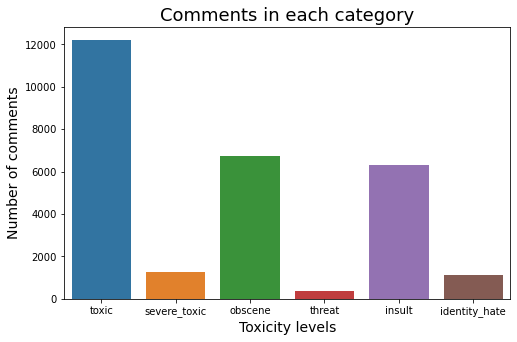

In [10]:
plt.figure(figsize=(8,5))
ax= sns.barplot(label_cols, train_[label_cols].sum().values)
plt.title("Comments in each category", fontsize=18)
plt.ylabel('Number of comments', fontsize=14)
plt.xlabel('Toxicity levels', fontsize=14)
plt.savefig('Number of comments in each category')

C:\Users\soura\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


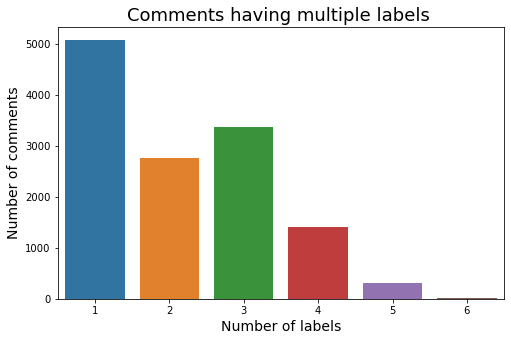

In [11]:
rowSums = train_[label_cols].sum(axis=1)
counts = rowSums.value_counts()
count= counts.iloc[1:]
plt.figure(figsize=(8,5))
ax = sns.barplot(count.index, count.values)
plt.title("Comments having multiple labels ",fontsize=18)
plt.ylabel('Number of comments', fontsize=14)
plt.xlabel('Number of labels', fontsize=14)
plt.savefig('Number of comments by number of labels')

In [12]:
#### Word2Vec

# tokenization 
tagged_data = [tokenize(_d) for i, _d in enumerate(train_['comment_text_new'])]
# build vocabulary from tokenized data
word_counts, vocabulary, vocabulary_inv = build_vocab(tagged_data)
# use the above mapping to create input data
inp_data = [[vocabulary[word] for word in text] for text in tagged_data]

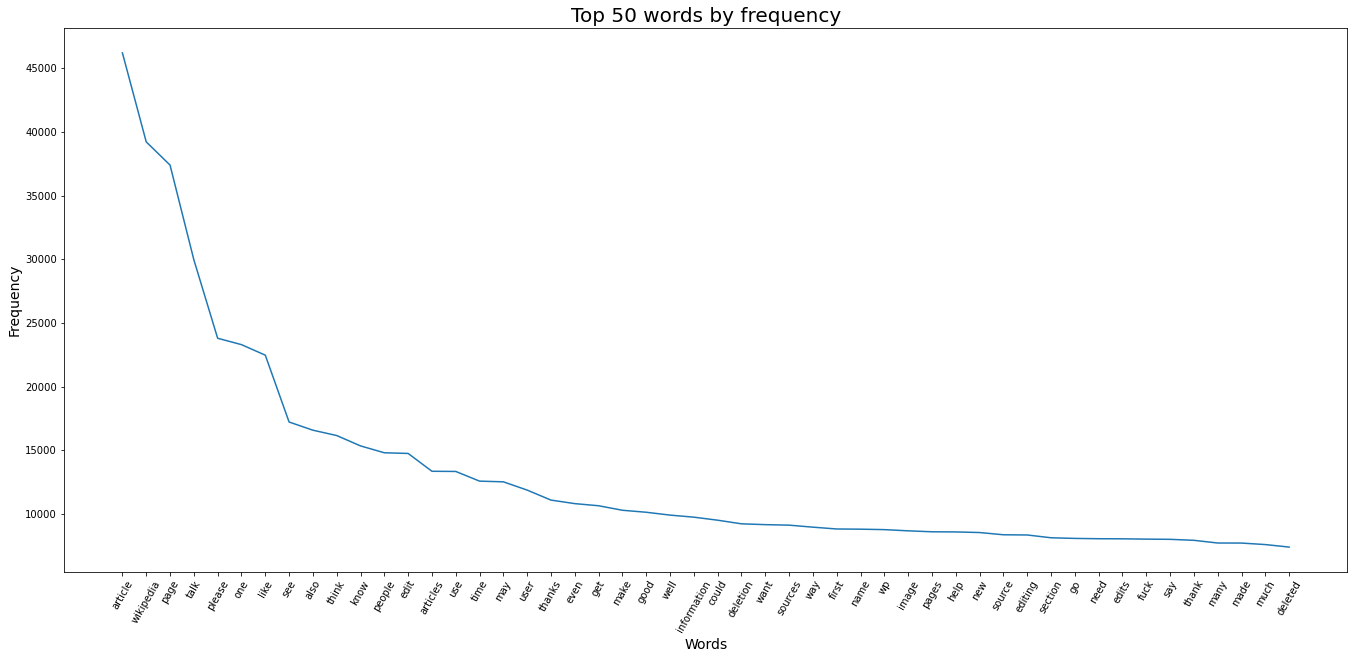

In [13]:
flat_list = [(word_counts[i],i) for i in word_counts]
flat_list.sort(reverse=True)

# fig, ax = plt.subplots(figsize=(30, 10))
# flat_list.plot(30, cumulative=False)
fig, ax = plt.subplots(figsize = (23,10))
ax.plot([i[1] for i in flat_list[:50]], [i[0] for i in flat_list[:50]])
ax.tick_params(axis='x',labelrotation=60)

plt.title("Top 50 words by frequency",fontsize=20)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.savefig('Top 50 words by frequency')

In [14]:
### Percentage of each labels in the train set
dict_label_percent = {}
for i in label_cols:
    dict_label_percent[i] = train_[i].mean()
    print(f'The percentage of {i} comments: {train_[i].mean()}')

The percentage of toxic comments: 0.095648494915148
The percentage of severe_toxic comments: 0.010005171035930864
The percentage of obscene comments: 0.052768071203597784
The percentage of threat comments: 0.0030242725292633625
The percentage of insult comments: 0.049305044110503474
The percentage of identity_hate comments: 0.008790761082470188


### Baseline model

In [18]:
CountVec = CountVectorizer(ngram_range=(1,1),tokenizer = lambda x:x.split())
bow_X_train = CountVec.fit_transform(train_['comment_text_new'])
bow_X_test = CountVec.transform(test_['comment_text_new'])

In [27]:
model = OneVsRestClassifier(MultinomialNB()).fit(bow_X_train, train_[label_cols])

preds = model.predict_proba(bow_X_test)
preds_train = model.predict_proba(bow_X_train)
preds_train_df = output_dataframe(preds_train, dict_label_percent, label_cols)
preds_df = output_dataframe(preds, dict_label_percent, label_cols)
model_outputs['NaiveBayes_BOW'] = {}
model_outputs['NaiveBayes_BOW']['training'] = score_multilabel(train_, preds_train_df,label_cols,pred_col_additional_string='_lb')
model_outputs['NaiveBayes_BOW']['test'] = score_multilabel(test_, preds_df,label_cols,pred_col_additional_string='_lb')


#### TF-IDF

In [28]:
#### Tf-IDF
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.7, strip_accents='unicode', use_idf=3,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train_['comment_text'])
test_term_doc = vec.transform(test_['comment_text'])

In [99]:
x = trn_term_doc
test_x = test_term_doc
preds = np.zeros((len(test_), len(label_cols)))
preds_train = np.zeros((len(train_), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train_[j],C=3, solver = 'liblinear', max_iter=10000)
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]
    preds_train[:,i] = m.predict_proba(x.multiply(r))[:,1]

preds_train_df = output_dataframe(preds_train, dict_label_percent, label_cols)
preds_df = output_dataframe(preds, dict_label_percent, label_cols)
# model_outputs['Logistic_Naivebayes_TF-IDF'] = {}
# model_outputs['Logistic_Naivebayes_TF-IDF']['training'] = score_multilabel(train_, preds_train_df,label_cols,pred_col_additional_string='_lb')
# model_outputs['Logistic_Naivebayes_TF-IDF']['test'] = score_multilabel(test_, preds_df,label_cols,pred_col_additional_string='_lb')


fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


#### Word2Vec

In [31]:
embedding_weights = get_embeddings(inp_data, vocabulary_inv,'word2vec',weight_z=0.025,size_features=250,min_word_count=10,context=60)

tagged_train_data = [tokenize(_d) for i, _d in enumerate(train_['comment_text_new'])]
tagged_test_data = [tokenize(_d) for i, _d in enumerate(test_['comment_text_new'])]

train_vec = []
for doc in tagged_train_data:
    vec = 0
    for w in doc:
        vec += embedding_weights[vocabulary[w]]

    vec = vec / len(doc)
    train_vec.append(vec)

test_vec = []
for doc in tagged_test_data:
    vec = 0
    length = 0
    for w in doc:
        try:
            vec += embedding_weights[vocabulary[w]]
            length += 1
        except:
            continue
            
    if length==0:
        vec = np.random.uniform(-1*0.025, 0.025, 250)
    else:
        vec = vec / length
    test_vec.append(vec)


In [32]:
x = scipy.sparse.csr_matrix(train_vec)
test_x = scipy.sparse.csr_matrix(test_vec)
preds = np.zeros((len(test_), len(label_cols)))



for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train_[j],C=3, penalty = 'l2', solver = 'liblinear', max_iter=10000)
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]
    preds_train[:,i] = m.predict_proba(x.multiply(r))[:,1]

preds_train_df = output_dataframe(preds_train, dict_label_percent, label_cols)
preds_df = output_dataframe(preds, dict_label_percent, label_cols)
model_outputs['Logistic_Naivebayes_Word2Vec'] = {}
model_outputs['Logistic_Naivebayes_Word2Vec']['training'] = score_multilabel(train_, preds_train_df,label_cols,pred_col_additional_string='_lb')
model_outputs['Logistic_Naivebayes_Word2Vec']['test'] = score_multilabel(test_, preds_df,label_cols,pred_col_additional_string='_lb')


fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [33]:
x = scipy.sparse.csr_matrix(train_vec)
test_x = scipy.sparse.csr_matrix(test_vec)

model = OneVsRestClassifier(LogisticRegression(C=23, penalty = 'l2', solver = 'liblinear', max_iter=10000)).fit(x,train_[label_cols].values)
preds = model.predict_proba(test_x)
preds_train = model.predict_proba(x)
preds_train_df = output_dataframe(preds_train, dict_label_percent, label_cols)
preds_df = output_dataframe(preds, dict_label_percent, label_cols)
model_outputs['Logistic_Word2Vec'] = {}
model_outputs['Logistic_Word2Vec']['training'] = score_multilabel(train_, preds_train_df,label_cols,pred_col_additional_string='_lb')
model_outputs['Logistic_Word2Vec']['test'] = score_multilabel(test_, preds_df,label_cols,pred_col_additional_string='_lb')


In [34]:
list_sentences_train = train_["comment_text_new"].fillna("_na_").values
list_sentences_test = test_["comment_text_new"].fillna("_na_").values

In [35]:
embed_size = 250 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [36]:
embeddings_index = {o:embedding_weights[vocabulary[o]] for o in vocabulary}

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

C:\Users\soura\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [55]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_t, train_[label_cols], batch_size=100, epochs=2, validation_data = (X_te,test_[label_cols]))

Epoch 1/2
1277/1277 [==============================] - 698s 544ms/step - loss: 0.0642 - accuracy: 0.8174 - val_loss: 0.0477 - val_accuracy: 0.9932
Epoch 2/2
1277/1277 [==============================] - 704s 551ms/step - loss: 0.0435 - accuracy: 0.9462 - val_loss: 0.0458 - val_accuracy: 0.9927


In [56]:
preds = model.predict(X_te)
preds_train = model.predict(X_t)
preds_train_df = output_dataframe(preds_train, dict_label_percent, label_cols)
preds_df = output_dataframe(preds, dict_label_percent, label_cols)
preds_train_df['severe_toxic_lb'] = np.where(preds_train_df['toxic_lb']==0,0,preds_train_df['severe_toxic_lb'])
preds_df['severe_toxic_lb'] = np.where(preds_df['toxic_lb']==0,0,preds_df['severe_toxic_lb'])
print(score_multilabel(train_, preds_train_df,label_cols,pred_col_additional_string='_lb'))
score_multilabel(test_, preds_df,label_cols,pred_col_additional_string='_lb')


(0.9555955160855549, 0.43805181355315476, 0.32558409558141, 0.9772535753555732)


(0.9382880834071293,
 0.4237412969128485,
 0.31580274899215943,
 0.9434568417602484)

In [63]:
print(score_multilabel(train_, preds_train_df,label_cols,pred_col_additional_string='_lb'))
score_multilabel(test_, preds_df,label_cols,pred_col_additional_string='_lb')


(0.9555955160855549, 0.5835792617081189, 0.32558409558141, 0.9772535753555732)


(0.9382880834071293,
 0.5632945514815759,
 0.31580274899215943,
 0.9434568417602484)

In [38]:
preds = model.predict(X_te)
preds_train = model.predict(X_t)
preds_train_df = output_dataframe(preds_train, dict_label_percent, label_cols)
preds_df = output_dataframe(preds, dict_label_percent, label_cols)
preds_train_df['severe_toxic_lb'] = np.where(preds_train_df['toxic_lb']==0,0,preds_train_df['severe_toxic_lb'])
preds_df['severe_toxic_lb'] = np.where(preds_df['toxic_lb']==0,0,preds_df['severe_toxic_lb'])

model_outputs['LSTM_Word2Vec'] = {}
model_outputs['LSTM_Word2Vec']['training'] = score_multilabel(train_, preds_train_df,label_cols,pred_col_additional_string='_lb')
model_outputs['LSTM_Word2Vec']['test'] = score_multilabel(test_, preds_df,label_cols,pred_col_additional_string='_lb')


#### Glove

In [40]:
glove_file = 'C:/Users/soura/OneDrive/Documents/UCSD/MGTA 415/glove.6B/glove.6B.300d.txt'

tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)

model_glove = KeyedVectors.load_word2vec_format(tmp_file)

C:\Users\soura\AppData\Local\Temp/ipykernel_19432/1783115207.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


In [41]:
embedding_weights = get_embeddings(inp_data, vocabulary_inv,'glove',weight_z=0.025)

tagged_train_data = [tokenize(_d) for i, _d in enumerate(train_['comment_text_new'])]
tagged_test_data = [tokenize(_d) for i, _d in enumerate(test_['comment_text_new'])]

train_vec = []
for doc in tagged_train_data:
    vec = 0
    for w in doc:
        vec += embedding_weights[vocabulary[w]]
    vec = vec / len(doc)
    train_vec.append(vec)

test_vec = []
for doc in tagged_test_data:
    vec = 0
    length = 0
    for w in doc:
        try:
            vec += embedding_weights[vocabulary[w]]
            length += 1
        except:
            continue
            
    if length==0:
        vec = np.random.uniform(-1*0.025, 0.025, 300)
    else:
        vec = vec / length
    test_vec.append(vec)


In [42]:
x = scipy.sparse.csr_matrix(train_vec)
test_x = scipy.sparse.csr_matrix(test_vec)
preds = np.zeros((len(test_), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train_[j],C=3, penalty = 'l2', solver = 'liblinear', max_iter=10000)
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]
    preds_train[:,i] = m.predict_proba(x.multiply(r))[:,1]

preds_train_df = output_dataframe(preds_train, dict_label_percent, label_cols)
preds_df = output_dataframe(preds, dict_label_percent, label_cols)
model_outputs['Logistic_Naivebayes_GloVe'] = {}
model_outputs['Logistic_Naivebayes_GloVe']['training'] = score_multilabel(train_, preds_train_df,label_cols,pred_col_additional_string='_lb')
model_outputs['Logistic_Naivebayes_GloVe']['test'] = score_multilabel(test_, preds_df,label_cols,pred_col_additional_string='_lb')


fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [43]:
x = scipy.sparse.csr_matrix(train_vec)
test_x = scipy.sparse.csr_matrix(test_vec)

model = OneVsRestClassifier(LogisticRegression(C=23, penalty = 'l2', solver = 'liblinear', max_iter=10000)).fit(x,train_[label_cols].values)
preds = model.predict_proba(test_x)
preds_df = output_dataframe(preds, dict_label_percent, label_cols)
preds_train = model.predict_proba(x)
preds_train_df = output_dataframe(preds_train, dict_label_percent, label_cols)
preds_df = output_dataframe(preds, dict_label_percent, label_cols)
model_outputs['Logistic_GloVe'] = {}
model_outputs['Logistic_GloVe']['training'] = score_multilabel(train_, preds_train_df,label_cols,pred_col_additional_string='_lb')
model_outputs['Logistic_GloVe']['test'] = score_multilabel(test_, preds_df,label_cols,pred_col_additional_string='_lb')


In [44]:
list_sentences_train = train_["comment_text_new"].fillna("_na_").values
list_sentences_test = test_["comment_text_new"].fillna("_na_").values

In [45]:
embed_size = 300 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [46]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(glove_file,encoding='utf8'))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

C:\Users\soura\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [47]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_t, train_[label_cols], batch_size=100, epochs=2, validation_data = (X_te,test_[label_cols]))

Epoch 1/2
1277/1277 [==============================] - 676s 527ms/step - loss: 0.0638 - accuracy: 0.8821 - val_loss: 0.0475 - val_accuracy: 0.9943
Epoch 2/2
1277/1277 [==============================] - 701s 549ms/step - loss: 0.0432 - accuracy: 0.9497 - val_loss: 0.0466 - val_accuracy: 0.9937


In [121]:
preds = model.predict(X_te)
preds_train = model.predict(X_t)
preds_train_df = output_dataframe(preds_train, dict_label_percent, label_cols)
preds_df = output_dataframe(preds, dict_label_percent, label_cols)


In [49]:
preds_train_df = output_dataframe(preds_train, dict_label_percent, label_cols)
preds_df = output_dataframe(preds, dict_label_percent, label_cols)
preds_train_df['severe_toxic_lb'] = np.where(preds_train_df['toxic_lb']==0,0,preds_train_df['severe_toxic_lb'])
preds_df['severe_toxic_lb'] = np.where(preds_df['toxic_lb']==0,0,preds_df['severe_toxic_lb'])

model_outputs['LSTM_GloVe'] = {}
model_outputs['LSTM_GloVe']['training'] = score_multilabel(train_, preds_train_df,label_cols,pred_col_additional_string='_lb')
model_outputs['LSTM_GloVe']['test'] = score_multilabel(test_, preds_df,label_cols,pred_col_additional_string='_lb')

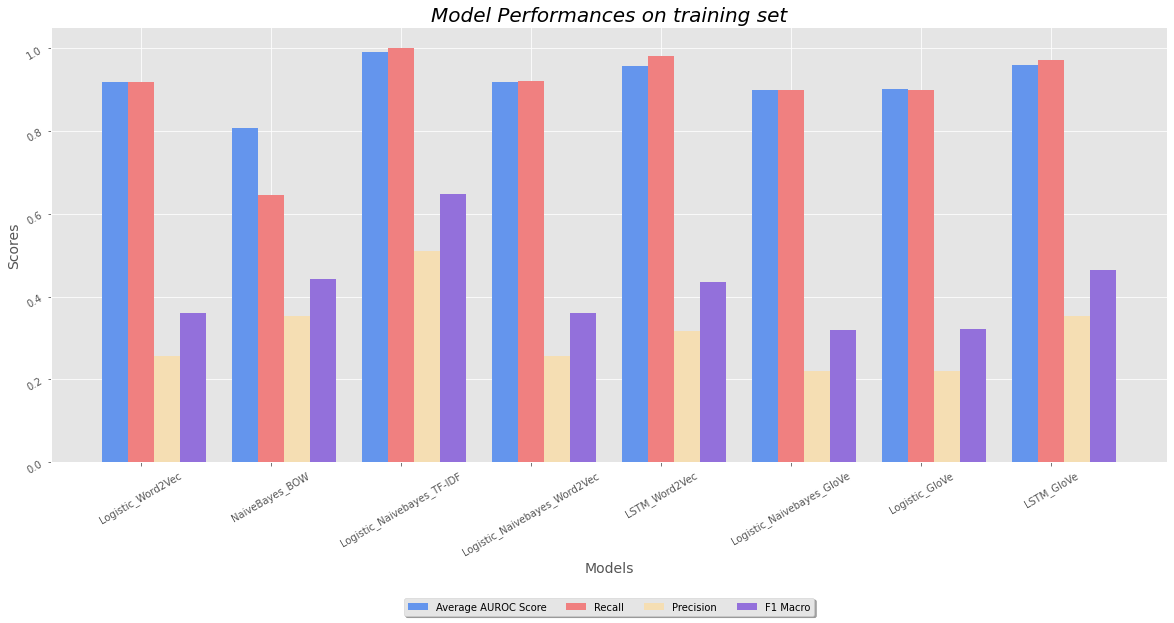

In [84]:
avg_auroc_ = [model_outputs[i]['training'][0] for i in model_outputs]
f1_macro = [model_outputs[i]['training'][1] for i in model_outputs]
precision_ = [model_outputs[i]['training'][2] for i in model_outputs]
recall_ = [model_outputs[i]['training'][3] for i in model_outputs]
width = 0.2
x = np.arange(8)

plt.figure(figsize=(20,8))
plt.style.use('ggplot')
#sns.color_palette("crest", as_cmap=True)
plt.bar(x-0.2, avg_auroc_, width, color='cornflowerblue')
plt.bar(x, recall_, width, color='lightcoral')
plt.bar(x+0.2, precision_, width, color='wheat')
plt.bar(x+0.4, f1_macro, width, color='mediumpurple')

plt.xticks(x, model_outputs.keys())
plt.xlabel("Models",fontsize=14)
plt.ylabel("Scores",fontsize=14)
plt.legend(["Average AUROC Score", "Recall", "Precision", "F1 Macro"],loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=5)
plt.title(label='Model Performances on training set',
          fontstyle='italic',fontsize=20)

plt.tick_params(labelrotation=30)

#plt.savefig('Model Performances on training set')


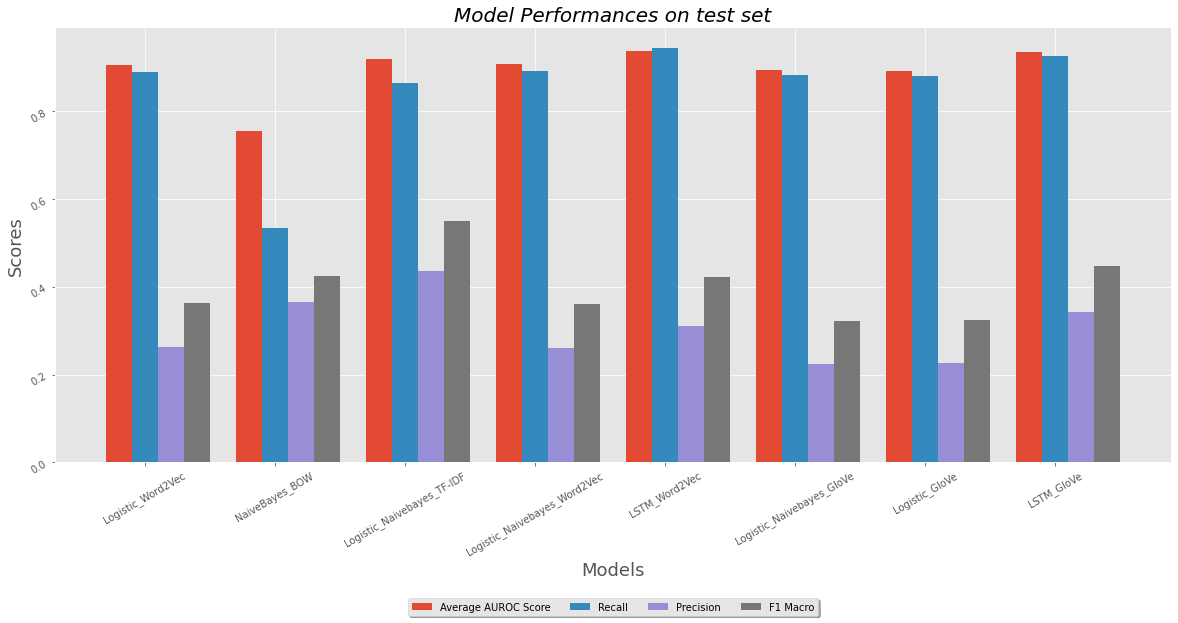

In [87]:
avg_auroc_ = [model_outputs[i]['test'][0] for i in model_outputs]
f1_macro = [model_outputs[i]['test'][1] for i in model_outputs]
precision_ = [model_outputs[i]['test'][2] for i in model_outputs]
recall_ = [model_outputs[i]['test'][3] for i in model_outputs]
width = 0.2
x = np.arange(8)

plt.figure(figsize=(20,8))
plt.style.use('ggplot')
plt.bar(x-0.2, avg_auroc_, width)
plt.bar(x, recall_, width)
plt.bar(x+0.2, precision_, width)
plt.bar(x+0.4, f1_macro, width)

plt.xticks(x, model_outputs.keys())
plt.xlabel("Models",fontsize=18)
plt.ylabel("Scores",fontsize=18)
plt.legend(["Average AUROC Score", "Recall", "Precision", "F1 Macro"],loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=5)
plt.title(label='Model Performances on test set',
          fontstyle='italic',fontsize=20)

plt.tick_params(labelrotation=30)

#plt.savefig('Model Performances on test set')

In [93]:
train_set_performance = pd.DataFrame.from_dict({i: model_outputs[i][j] 
                           for i in model_outputs.keys() 
                           for j in model_outputs[i].keys() if j=='training'},
                       orient='index', columns = ['Average AUROC Score','Macro F1','Precision','Recall'])
test_set_performance = pd.DataFrame.from_dict({i: model_outputs[i][j] 
                           for i in model_outputs.keys() 
                           for j in model_outputs[i].keys() if j=='test'},
                       orient='index', columns = ['Average AUROC Score','Macro F1','Precision','Recall'])
train_set_performance

,Average AUROC Score,Macro F1,Precision,Recall
Logistic_Word2Vec,0.917142,0.360411,0.256951,0.917739
NaiveBayes_BOW,0.806660,0.441750,0.351998,0.644887
Logistic_Naivebayes_TF-IDF,0.988890,0.646668,0.509882,0.999260
Logistic_Naivebayes_Word2Vec,0.918037,0.359615,0.256085,0.920808
LSTM_Word2Vec,0.956578,0.434056,0.317716,0.980388
Logistic_Naivebayes_GloVe,0.899451,0.319731,0.219969,0.899196
Logistic_GloVe,0.899604,0.321280,0.221277,0.897916
LSTM_GloVe,0.958773,0.463163,0.354066,0.971360


In [94]:
test_set_performance

,Average AUROC Score,Macro F1,Precision,Recall
Logistic_Word2Vec,0.905521,0.362659,0.262428,0.889186
NaiveBayes_BOW,0.754191,0.424081,0.364130,0.533227
Logistic_Naivebayes_TF-IDF,0.918562,0.550817,0.435618,0.864538
Logistic_Naivebayes_Word2Vec,0.906278,0.360501,0.260239,0.892450
LSTM_Word2Vec,0.937825,0.421542,0.309579,0.943489
Logistic_Naivebayes_GloVe,0.892929,0.321463,0.224071,0.883492
Logistic_GloVe,0.892560,0.323129,0.225484,0.881088
LSTM_GloVe,0.935214,0.446651,0.343219,0.924530


#### Overall toxicity prediction

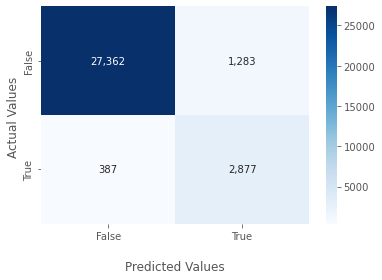

In [120]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(preds_df_new['toxics_actual'], preds_df_new['toxics_pred'])

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt=',g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

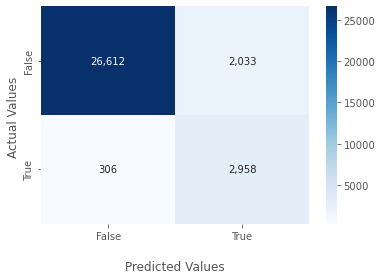

In [124]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(preds_df_new['toxics_actual'], preds_df_new['toxics_pred'])

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt=',g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()